## Setup

In [598]:
import numpy as np
import xarray as xr
import pandas as pd

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import neighbors
from sklearn.pipeline import Pipeline

import xgboost
import shap

from nilearn import datasets as nilean_datasets

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

shap.initjs()

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-19T02:13:21.884373+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

nilearn   : 0.9.0
shap      : 0.40.0
numpy     : 1.21.5
matplotlib: 3.5.1
xgboost   : 1.5.1
json      : 2.0.9
seaborn   : 0.11.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
plotly    : 5.5.0
sklearn   : 1.0.2
pandas    : 1.4.0
ipykernel : 6.9.0
xarray    : 0.21.1
debugpy   : 1.5.1



In [570]:
# parameters

TRIU_K = 0
DATASET_NAME = 'difumo_64_2_precision'

## Data

In [571]:
atlases = ['dosenbach2007', 'difumo_64_2',]# 'difumo_128_2',]# 'difumo_1024_2']

connectivity_measures = ['tangent', 'precision', 'correlation',
                         'covariance', 'partial_correlation']

DATASETS = dict()

for atlas in atlases:
  for connectivity in connectivity_measures:
    _conn_key = f'{connectivity}_connectivity'
    ds = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
    _conn = ds[_conn_key]
    _conn.coords['group'] = ds.group
    _conn['inverse_efficiency_score_ms'] = ds['inverse_efficiency_score_ms']
    DATASETS[f'{atlas}_{connectivity}'] = _conn
    
    if 'difumo_names' in ds.coords:
      _conn.coords['region'] = ds.coords['difumo_names'].values


In [572]:
dataset = DATASETS[DATASET_NAME]

behavioral_scores = ds['inverse_efficiency_score_ms'].values

# remove subjects with missing behavioral data or duplicate scanning sessions
# subject_labels = xr.concat([dataset['subject'], dataset['subject'] + 'NEW'], dim='subject')
# invalid_subjects = subject_labels.to_series().duplicated(keep='first')[34:]
# invalid_subjects = invalid_subjects | np.isnan(behavioral_scores)
invalid_subjects = np.isnan(behavioral_scores)

In [573]:
regions = dataset.coords['region'].values

feature_names = pd.DataFrame(
  np.empty((len(regions), len(regions))),
  index=regions, columns=regions)

feature_names = feature_names.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=TRIU_K)]

# X
X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=TRIU_K)]
              for subj_conn in dataset.values])

X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

# y
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(ds['group'])

# remove subjects with missing behavioral data
X = X[~invalid_subjects]
y = y[~invalid_subjects]



## Model

In [574]:

# ALT 1: SVM
model = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold(.01)),
    ('model', svm.SVC(kernel='rbf', C=1, probability=True)),
], verbose=False)

# ALT2: RandomForest
model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

# ALT3: XGBoost
model = xgboost.XGBClassifier(
    n_estimators=100, max_depth=10,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1)

# TODO hyper-parameter tuning

train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.5,
  shuffle=True,
  stratify=y,
)

model.fit(X[train], y[train])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [575]:
%%script echo skipping...

# DEBUG /start

test_score = model_selection.cross_val_score(
    model, X, y, n_jobs=-1, scoring='roc_auc',
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20),
)

print(f'mean(CV-AUC): {test_score.mean():.2f}')

perm_score, _, pvalue = model_selection.permutation_test_score(
    model, X, y,
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10),
    n_jobs=-1,
    n_permutations=10,
    # cv=5,
    scoring='roc_auc')

print(f'Permutation test AUC: {perm_score:.2f} (p-value={pvalue:.3f})')

# DEBUG /end

mean(CV-AUC): 0.57


## CV-SHAP

In [576]:
shap_values_cv = []
X_test_indices_cv = []
y_test_cv = []

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=100)

n_splits = cv.get_n_splits(X, y)

for train, test in tqdm(cv.split(X, y), total=n_splits):

    # train the model
    model.fit(X[train], y[train])
    
    # # fit explainer
    explainer = shap.Explainer(
        model, X[train],
        feature_names=feature_names,
        algorithm='tree',
        output_names=dataset['group'].values[train]
    )

    # evaluate explainer
    shap_values = explainer(X[test])#, max_evals= 100 * X.shape[1] + 1)

    shap_values_cv.append(shap_values.values)
    X_test_indices_cv.append(test)
    y_test_cv.append(y[test])

# merge CV results
shap_values = np.vstack(shap_values_cv)
X_test = pd.DataFrame(X[np.hstack(X_test_indices_cv)], columns=feature_names)
y_test = np.hstack(y_test_cv)

100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


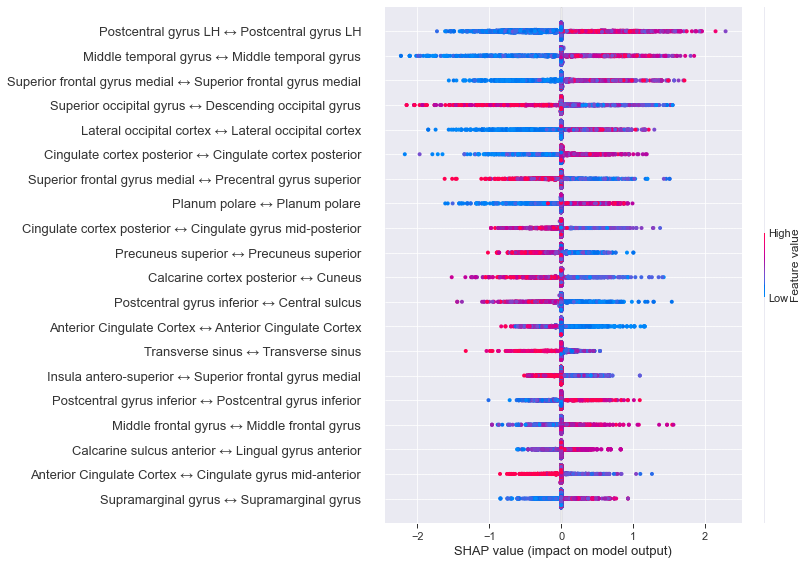

In [577]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

In [578]:
# TODO use explainers to calculate base and subsample to speed up plotting
# shap.force_plot(.5, shap_values[:,:,0], X_test, feature_names=feature_names)

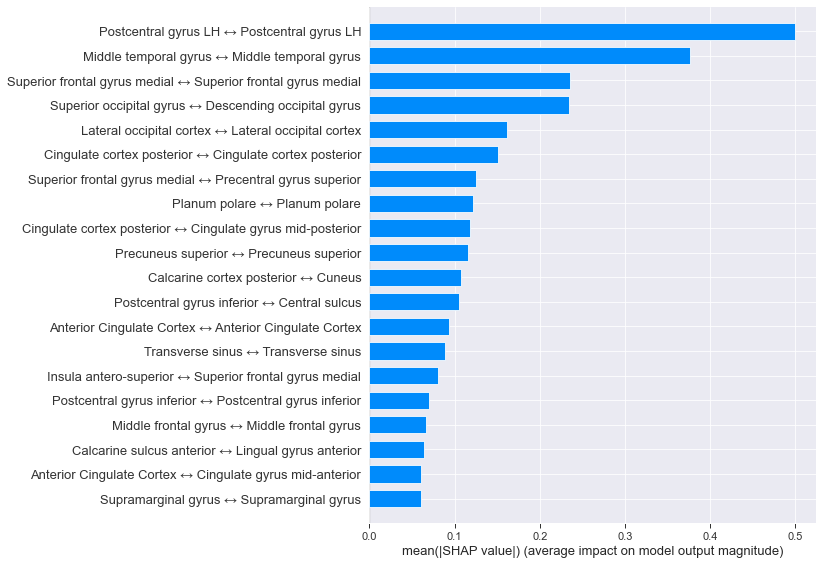

In [582]:
clustering = None
# clustering = shap.utils.hclust(X_test.iloc[:,:10], y_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [599]:
shap2d_size = len(dataset.coords['region'])

agg_shap_values = np.abs(shap_values).sum(axis=0)
# agg_shap_values = shap_values.abs.sum(0).values


shap2d_values = np.zeros((shap2d_size, shap2d_size))
shap2d_triu_indices = np.triu_indices(shap2d_size, k=TRIU_K)
shap2d_values[shap2d_triu_indices] = agg_shap_values
shap2d_values = shap2d_values + shap2d_values.T - np.diag(np.diag(shap2d_values))

shap2d = pd.DataFrame(shap2d_values,
                      index=dataset.coords['region'],
                      columns=dataset.coords['region'])


sorted_shap_indices = np.argsort(agg_shap_values)[::-1]
top_n = 10
triu_idx = sorted_shap_indices[:top_n]
row_idx = np.triu_indices(shap2d_size, k=TRIU_K)[0][triu_idx]
col_idx = np.triu_indices(shap2d_size, k=TRIU_K)[1][triu_idx]

# DEBUG make sure indices are mapped correctly
assert np.all(shap2d_values[row_idx,col_idx] == agg_shap_values[triu_idx])


def get_yeo_networks17(region, atlas=None):

  if atlas is None:
    atlas = nilean_datasets.fetch_atlas_difumo(
      dimension=64, resolution_mm=2, legacy_format=False)

    labels = atlas.labels.set_index('difumo_names')

  return labels.loc[region,'yeo_networks17']


print('Top contributing connectivities:')
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
  # print(f'{shap2d.index[i]} - {shap2d.columns[j]}')
  row_region = dataset.coords['region'].values[row]
  col_region = dataset.coords['region'].values[col]
  row_net = get_yeo_networks17(row_region)
  col_net = get_yeo_networks17(col_region)  
  print(f'{i+1}) {row_region} \N{left right arrow} {col_region} '
        f'[{row_net} \N{left right arrow} {col_net}]')

Top contributing connectivities:
1) Postcentral gyrus LH ↔ Postcentral gyrus LH [DorsAttnB ↔ DorsAttnB]
2) Middle temporal gyrus ↔ Middle temporal gyrus [DefaultB ↔ DefaultB]
3) Superior frontal gyrus medial ↔ Superior frontal gyrus medial [SalVentAttnA ↔ SalVentAttnA]
4) Superior occipital gyrus ↔ Descending occipital gyrus [VisPeri ↔ VisCent]
5) Lateral occipital cortex ↔ Lateral occipital cortex [DorsAttnA ↔ DorsAttnA]
6) Cingulate cortex posterior ↔ Cingulate cortex posterior [DefaultA ↔ DefaultA]
7) Superior frontal gyrus medial ↔ Precentral gyrus superior [SalVentAttnA ↔ DorsAttnB]
8) Planum polare ↔ Planum polare [SomMotB ↔ SomMotB]
9) Cingulate cortex posterior ↔ Cingulate gyrus mid-posterior [DefaultA ↔ ContC]
10) Precuneus superior ↔ Precuneus superior [ContC ↔ ContC]


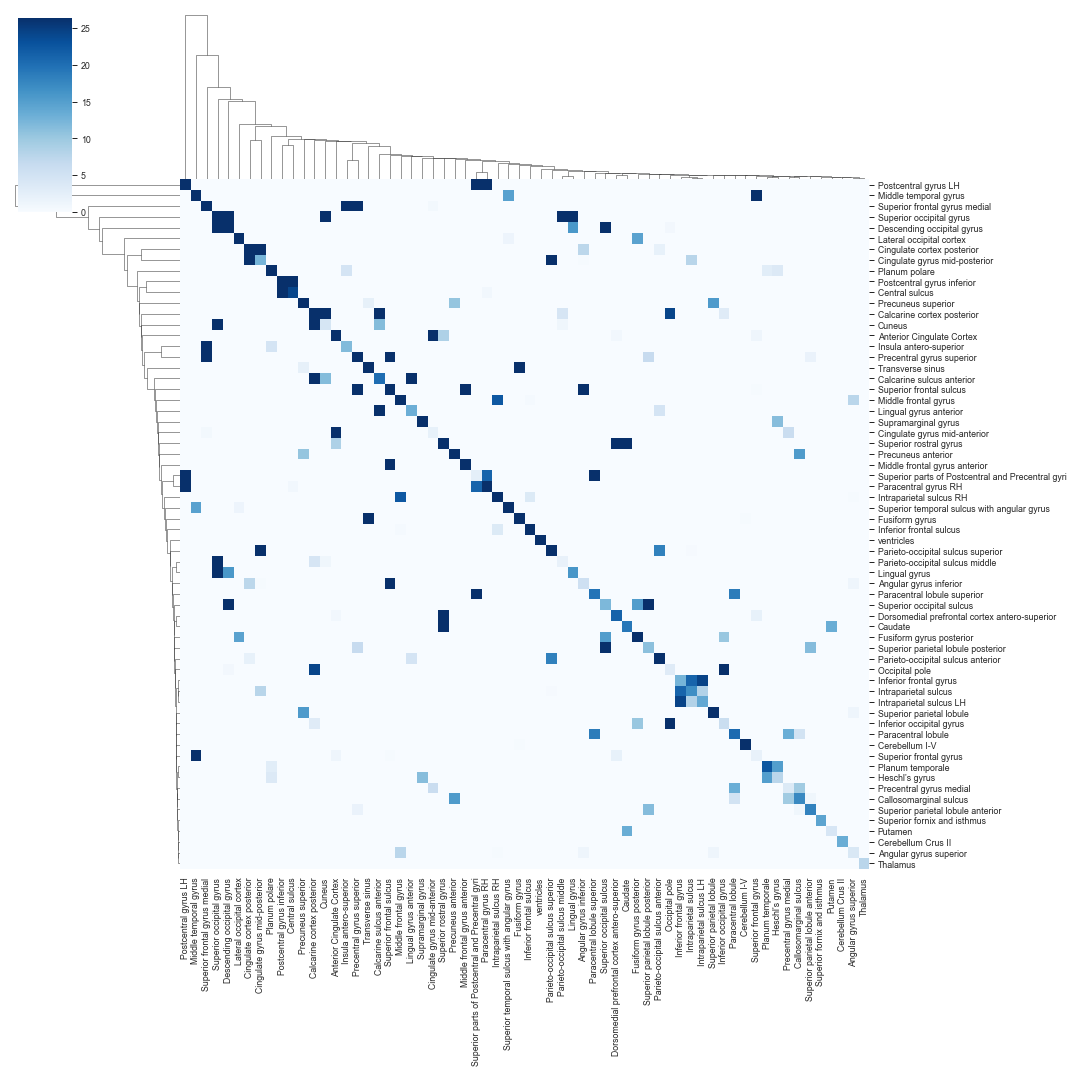

In [602]:
sns.clustermap(shap2d, figsize=(15,15), robust=True, cmap='Blues')
plt.show()

## interactive heatmap (but not clustered)
# fig = px.imshow(shap2d, aspect='auto', height=800)
# fig.show()